In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

class DatasetHolder:
    def __init__(self, X_train, y_train, X_dev, y_dev, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        
        self.X_dev = X_dev
        self.y_dev = y_dev
        
        self.X_test = X_test
        self.y_test = y_test

def split_simple(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    
    return DatasetHolder(X_train, y_train, X_dev, y_dev, X_test, y_test)

def load_csv(path):
    return pd.read_csv(path)

def load_dataset(path):
    print(f"Loading dataset from {path}...")
    df = load_csv(path)
    X_full, y_full = df.drop('next_time_in_hospital', axis=1).values, df['next_time_in_hospital'].values
    print(f"Shape of dataset: {X_full.shape}")
    
    return split_simple(X_full, y_full)

In [2]:
simple = load_dataset("nn_allcats_ds.csv")

Loading dataset from nn_allcats_ds.csv...
Shape of dataset: (30248, 1903)


In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_tweedie_deviance
import time

def train_model_for_seconds(dataset, model, seconds=30, batch_size=None):
    start_time = time.time()
    # your code
    
    epochs = 0
    loss_hist = []
    val_loss_hist = []
    
    while time.time() - start_time < seconds:
        cur = model.fit(dataset.X_train, dataset.y_train, batch_size=batch_size, epochs=1, 
                        validation_data=(dataset.X_dev, dataset.y_dev))
        
        for el in cur.history['loss']:
            loss_hist.append(el)
        
        for el in cur.history['val_loss']:
            val_loss_hist.append(el)
        
        epochs += 1
    
    elapsed = time.time() - start_time
    print(f"Trained model on {epochs} epochs for time {elapsed} secs ({epochs/elapsed} epochs in second)")
    
    print("Loss history:")
    plt.plot(range(len(loss_hist)), loss_hist, label='loss')
    plt.plot(range(len(val_loss_hist)), val_loss_hist, label='val_loss')

def eval_model(dataset, model, batch_size=None):
    train_model_for_seconds(dataset, model, batch_size=batch_size)
    predictions = model.predict(dataset.X_dev)
    ret = f"mean squared error: {mean_squared_error(dataset.y_dev, predictions)}"# , poisson: {mean_tweedie_deviance(dataset.y_dev, predictions, power=1)}"
    
    diffs = dataset.y_dev - predictions[:, 0]
    plt.hist(diffs)
    
    return ret

In [4]:
def get_perceptron_m(dataset):
    perceptron_m = tf.keras.Sequential([
        tf.keras.layers.Dense(1, input_shape=(dataset.X_train.shape[1],))
    ])
    perceptron_m.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error')
    
    return perceptron_m

perceptron_m = get_perceptron_m(simple)

In [5]:
def get_two_layer_m(dataset):
    two_layer_m = tf.keras.Sequential([
        tf.keras.layers.Dense(simple.X_train.shape[1], input_shape=(dataset.X_train.shape[1],), activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    two_layer_m.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error')
    
    return two_layer_m

two_layer_m = get_two_layer_m(simple)

In [6]:
def get_three_layer_m(dataset):
    three_layer_m = tf.keras.Sequential([
        tf.keras.layers.Dense(simple.X_train.shape[1], input_shape=(dataset.X_train.shape[1],), activation='relu'),
        tf.keras.layers.Dense(simple.X_train.shape[1], activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    three_layer_m.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error')
    
    return three_layer_m

three_layer_m = get_three_layer_m(simple)

In [7]:
def get_four_layer_m(dataset):
    four_layer_m = tf.keras.Sequential([
        tf.keras.layers.Dense(simple.X_train.shape[1], input_shape=(dataset.X_train.shape[1],), activation='relu'),
        tf.keras.layers.Dense(simple.X_train.shape[1], activation='relu'),
        tf.keras.layers.Dense(simple.X_train.shape[1], activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    four_layer_m.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error')
    
    return four_layer_m

four_layer_m = get_four_layer_m(simple)

In [8]:
def get_expdec_four_layer_m(dataset):
    expdec_four_layer_m = tf.keras.Sequential([
        tf.keras.layers.Dense(simple.X_train.shape[1], input_shape=(dataset.X_train.shape[1],), activation='relu'),
        tf.keras.layers.Dense(simple.X_train.shape[1]**(1/2), activation='relu'),
        tf.keras.layers.Dense(simple.X_train.shape[1]**(1/4), activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    expdec_four_layer_m.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error')
    
    return expdec_four_layer_m

expdec_four_layer_m = get_expdec_four_layer_m(simple)

In [9]:
def get_expdec_three_layer_m(dataset):
    expdec_three_layer_m = tf.keras.Sequential([
        tf.keras.layers.Dense(simple.X_train.shape[1], input_shape=(dataset.X_train.shape[1],), activation='relu'),
        tf.keras.layers.Dense(simple.X_train.shape[1]**(1/2), activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    expdec_three_layer_m.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error')
    
    return expdec_three_layer_m

expdec_three_layer_m = get_expdec_three_layer_m(simple)

In [10]:
def get_expdec_smallstart_three_layer_m(dataset):
    expdec_smallstart_three_layer_m = tf.keras.Sequential([
        tf.keras.layers.Dense(simple.X_train.shape[1]**(1/4), input_shape=(dataset.X_train.shape[1],), activation='relu'),
        tf.keras.layers.Dense(simple.X_train.shape[1]**(1/8), activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    expdec_smallstart_three_layer_m.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error')
    
    return expdec_smallstart_three_layer_m

expdec_smallstart_three_layer_m = get_expdec_smallstart_three_layer_m(simple)

In [138]:
eval_model(simple, get_perceptron_m(simple), batch_size=simple.X_train.shape[0])

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 16us/sample - loss: 2.9436 - val_loss: 2.9427
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 9us/sample - loss: 2.8266 - val_loss: 2.8881
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 15us/sample - loss: 2.7174 - val_loss: 2.8362
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 31us/sample - loss: 2.6153 - val_loss: 2.7870
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 4s 199us/sample - loss: 2.5199 - val_loss: 2.7404
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 113us/sample - loss: 2.4306 - val_loss: 2.6960
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 10us/sample - loss: 2.3470 - v

ResourceExhaustedError:  OOM when allocating tensor with shape[19358,1903] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node Cast (defined at <ipython-input-137-ff4dbddebb5a>:15) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_297129]

Function call stack:
distributed_function


Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 17s 862us/sample - loss: 8.5468 - val_loss: 1.4097
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 17s 864us/sample - loss: 2.0686 - val_loss: 6.3922
Trained model on 2 epochs for time 33.88205361366272 secs (0.059028299252602355 epochs in second)
Loss history:


ValueError: Mean Tweedie deviance error with power=1 can only be used on non-negative y_true and strictly positive y_pred.

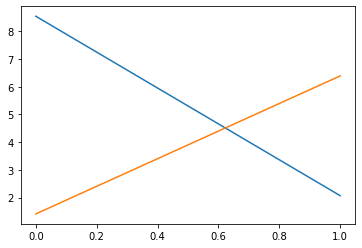

In [136]:
eval_model(simple, two_layer_m)

In [12]:
eval_model(simple, four_layer_m)

Train on 19358 samples
19358/19358 [==============================] - 5s 234us/sample - loss: 1.1040
Train on 19358 samples
19358/19358 [==============================] - 4s 225us/sample - loss: 973.0371
Train on 19358 samples
19358/19358 [==============================] - 4s 223us/sample - loss: 40.1512
Train on 19358 samples
19358/19358 [==============================] - 5s 240us/sample - loss: 2.7862
Train on 19358 samples
19358/19358 [==============================] - 7s 348us/sample - loss: 5.6102
Train on 19358 samples
19358/19358 [==============================] - 6s 331us/sample - loss: 2.5273
Trained model on 6 epochs for time 31.084725379943848 secs (0.19302084630515204 epochs in second)


1.0304242383632964

In [13]:
eval_model(simple, expdec_four_layer_m)

Train on 19358 samples
19358/19358 [==============================] - 1s 73us/sample - loss: 1.7560
Train on 19358 samples
19358/19358 [==============================] - 1s 64us/sample - loss: 3.7428
Train on 19358 samples
19358/19358 [==============================] - 1s 63us/sample - loss: 1.2118
Train on 19358 samples
19358/19358 [==============================] - 1s 63us/sample - loss: 1.6500
Train on 19358 samples
19358/19358 [==============================] - 1s 63us/sample - loss: 1.2785
Train on 19358 samples
19358/19358 [==============================] - 1s 65us/sample - loss: 0.9768
Train on 19358 samples
19358/19358 [==============================] - 1s 64us/sample - loss: 0.9262
Train on 19358 samples
19358/19358 [==============================] - 1s 63us/sample - loss: 0.9342
Train on 19358 samples
19358/19358 [==============================] - 1s 65us/sample - loss: 0.9285
Train on 19358 samples
19358/19358 [==============================] - 1s 64us/sample - loss: 0.9111


1.0436421808098189

In [14]:
eval_model(simple, expdec_three_layer_m)

Train on 19358 samples
19358/19358 [==============================] - 1s 72us/sample - loss: 1.9829
Train on 19358 samples
19358/19358 [==============================] - 1s 64us/sample - loss: 16.2460
Train on 19358 samples
19358/19358 [==============================] - 1s 63us/sample - loss: 2.5041
Train on 19358 samples
19358/19358 [==============================] - 1s 63us/sample - loss: 2.1665
Train on 19358 samples
19358/19358 [==============================] - 1s 63us/sample - loss: 4.0057
Train on 19358 samples
19358/19358 [==============================] - 1s 63us/sample - loss: 3.0615
Train on 19358 samples
19358/19358 [==============================] - 1s 63us/sample - loss: 1.7978
Train on 19358 samples
19358/19358 [==============================] - 1s 63us/sample - loss: 1.1043
Train on 19358 samples
19358/19358 [==============================] - 1s 64us/sample - loss: 0.8868
Train on 19358 samples
19358/19358 [==============================] - 1s 63us/sample - loss: 0.8863

1.0472048344340843

In [15]:
eval_model(simple, expdec_smallstart_three_layer_m) # Big overfit

Train on 19358 samples
19358/19358 [==============================] - 0s 19us/sample - loss: 2.5203
Train on 19358 samples
19358/19358 [==============================] - 0s 7us/sample - loss: 2.3404
Train on 19358 samples
19358/19358 [==============================] - 0s 7us/sample - loss: 2.1774
Train on 19358 samples
19358/19358 [==============================] - 0s 7us/sample - loss: 2.0306
Train on 19358 samples
19358/19358 [==============================] - 0s 7us/sample - loss: 1.8983
Train on 19358 samples
19358/19358 [==============================] - 0s 7us/sample - loss: 1.7797
Train on 19358 samples
19358/19358 [==============================] - 0s 7us/sample - loss: 1.6731
Train on 19358 samples
19358/19358 [==============================] - 0s 7us/sample - loss: 1.5780
Train on 19358 samples
19358/19358 [==============================] - 0s 7us/sample - loss: 1.4934
Train on 19358 samples
19358/19358 [==============================] - 0s 8us/sample - loss: 1.4186
Train on 

Train on 19358 samples
19358/19358 [==============================] - 0s 7us/sample - loss: 0.7776
Train on 19358 samples
19358/19358 [==============================] - 0s 7us/sample - loss: 0.7767
Train on 19358 samples
19358/19358 [==============================] - 0s 7us/sample - loss: 0.7758
Train on 19358 samples
19358/19358 [==============================] - 0s 7us/sample - loss: 0.7749
Train on 19358 samples
19358/19358 [==============================] - 0s 7us/sample - loss: 0.7740
Train on 19358 samples
19358/19358 [==============================] - 0s 7us/sample - loss: 0.7732
Train on 19358 samples
19358/19358 [==============================] - 0s 7us/sample - loss: 0.7723
Train on 19358 samples
19358/19358 [==============================] - 0s 7us/sample - loss: 0.7715
Train on 19358 samples
19358/19358 [==============================] - 0s 8us/sample - loss: 0.7708
Train on 19358 samples
19358/19358 [==============================] - 0s 7us/sample - loss: 0.7700
Train on 1

2.110585223783406

I tried straightforward testing on this dataset, including
* A single perceptron
* Densely connected 2 full-width layers
* Densely connected 4 full-width layers (overfits)
* Densely connected 4 layers with exponentially decreasing witdth
* Densely connected 3 layers -=-
* Densely connected 3 lyaers with exponentially decreasing width, but starting from smaller width in general

Those were only tried with ReLu activation function.

Learning rates turned out to be very important, so I switched from SGD to Adam optimizer, which uses an adaptive learning rate.

Turns out that models with smaller numer of units perform better (but too little become prone to overfitting)

A thing to try would be to better engineer features, so we have smaller number

In [11]:
compdiags = load_dataset("nn_compdiags_ds.csv")

Loading dataset from nn_compdiags_ds.csv...
Shape of dataset: (30248, 245)


Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 21us/sample - loss: 3.0292 - val_loss: 3.0285
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 3us/sample - loss: 2.9109 - val_loss: 2.9317
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 2.8008 - val_loss: 2.8415
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 2.6982 - val_loss: 2.7574
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 2.6024 - val_loss: 2.6787
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 2.5130 - val_loss: 2.6051
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 2.4294 - val_loss

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 1.0781 - val_loss: 1.3844
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 1.0721 - val_loss: 1.3788
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 1.0664 - val_loss: 1.3735
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 1.0609 - val_loss: 1.3684
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 1.0557 - val_loss: 1.3635
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 1.0507 - val_loss: 1.3588
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 1.0458 - val_loss:

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 3us/sample - loss: 0.9433 - val_loss: 1.2542
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 0.9426 - val_loss: 1.2536
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 0.9420 - val_loss: 1.2529
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 0.9414 - val_loss: 1.2523
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 0.9408 - val_loss: 1.2517
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 0.9403 - val_loss: 1.2511
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 0.9397 - val_loss:

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 8us/sample - loss: 0.9265 - val_loss: 1.2368
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 0.9264 - val_loss: 1.2366
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 3us/sample - loss: 0.9263 - val_loss: 1.2365
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 4s 182us/sample - loss: 0.9262 - val_loss: 1.2364
Trained model on 175 epochs for time 30.788166046142578 secs (5.684002085012972 epochs in second)
Loss history:


'mean squared error: 1.2364397530423024'

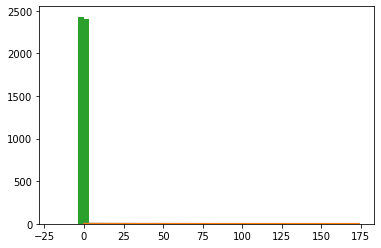

In [140]:
eval_model(compdiags, get_perceptron_m(compdiags), batch_size=compdiags.X_train.shape[0])

In [18]:
eval_model(compdiags, get_two_layer_m(compdiags))

Train on 19358 samples
19358/19358 [==============================] - 0s 26us/sample - loss: 1.1474
Train on 19358 samples
19358/19358 [==============================] - 0s 22us/sample - loss: 1.1125
Train on 19358 samples
19358/19358 [==============================] - 0s 15us/sample - loss: 0.9913
Train on 19358 samples
19358/19358 [==============================] - 0s 15us/sample - loss: 1.0369
Train on 19358 samples
19358/19358 [==============================] - 0s 16us/sample - loss: 0.9873
Train on 19358 samples
19358/19358 [==============================] - 0s 16us/sample - loss: 0.9318
Train on 19358 samples
19358/19358 [==============================] - 0s 16us/sample - loss: 0.9299
Train on 19358 samples
19358/19358 [==============================] - 0s 22us/sample - loss: 0.9217
Train on 19358 samples
19358/19358 [==============================] - 0s 18us/sample - loss: 0.8869
Train on 19358 samples
19358/19358 [==============================] - 0s 15us/sample - loss: 0.8634


Train on 19358 samples
19358/19358 [==============================] - 0s 15us/sample - loss: 0.4459
Train on 19358 samples
19358/19358 [==============================] - 0s 15us/sample - loss: 0.4424
Train on 19358 samples
19358/19358 [==============================] - 0s 15us/sample - loss: 0.4388
Train on 19358 samples
19358/19358 [==============================] - 0s 15us/sample - loss: 0.4353
Train on 19358 samples
19358/19358 [==============================] - 0s 15us/sample - loss: 0.4318
Train on 19358 samples
19358/19358 [==============================] - 0s 15us/sample - loss: 0.4283
Train on 19358 samples
19358/19358 [==============================] - 0s 15us/sample - loss: 0.4248
Train on 19358 samples
19358/19358 [==============================] - 0s 15us/sample - loss: 0.4214
Train on 19358 samples
19358/19358 [==============================] - 0s 15us/sample - loss: 0.4179
Train on 19358 samples
19358/19358 [==============================] - 0s 15us/sample - loss: 0.4145


1.1449172894842226

In [19]:
eval_model(compdiags, get_four_layer_m(compdiags))

Train on 19358 samples
19358/19358 [==============================] - 4s 188us/sample - loss: 1.0471
Train on 19358 samples
19358/19358 [==============================] - 3s 176us/sample - loss: 213.2748
Train on 19358 samples
19358/19358 [==============================] - 3s 177us/sample - loss: 11.7584
Train on 19358 samples
19358/19358 [==============================] - 3s 177us/sample - loss: 1.0086
Train on 19358 samples
19358/19358 [==============================] - 3s 177us/sample - loss: 1.6539
Train on 19358 samples
19358/19358 [==============================] - 3s 176us/sample - loss: 1.3225
Train on 19358 samples
19358/19358 [==============================] - 3s 177us/sample - loss: 1.0126
Train on 19358 samples
19358/19358 [==============================] - 3s 178us/sample - loss: 1.0594
Train on 19358 samples
19358/19358 [==============================] - 4s 197us/sample - loss: 1.1375
Trained model on 9 epochs for time 31.62170171737671 secs (0.28461466370275496 epochs in

1.0781475534342504

In [12]:
eval_model(compdiags, get_expdec_four_layer_m(compdiags))

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 4s 202us/sample - loss: 0.9792 - val_loss: 0.9777
Train on 19358 samples, validate on 4840 samples
 6592/19358 [=========>....................] - ETA: 2s - loss: 0.9362

KeyboardInterrupt: 

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 4s 187us/sample - loss: 0.9822 - val_loss: 0.9723
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 175us/sample - loss: 0.9293 - val_loss: 0.9679
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 177us/sample - loss: 0.9076 - val_loss: 0.9625
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 174us/sample - loss: 0.8881 - val_loss: 0.9752
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 177us/sample - loss: 0.8647 - val_loss: 0.9957
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 171us/sample - loss: 0.8385 - val_loss: 0.9777
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 175us/sample - loss: 0.79

'mean squared error: 1.1072548098696722'

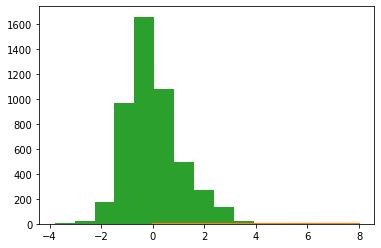

In [13]:
eval_model(compdiags, get_expdec_three_layer_m(compdiags))

In [22]:
eval_model(compdiags, get_expdec_smallstart_three_layer_m(compdiags))

Train on 19358 samples
19358/19358 [==============================] - 0s 11us/sample - loss: 1.2855
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 1.2657
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 1.2469
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 1.2292
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 1.2125
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 1.1967
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 1.1819
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 1.1681
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 1.1551
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 1.1430
Train on 

Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.9635
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.9630
Train on 19358 samples
19358/19358 [==============================] - 0s 3us/sample - loss: 0.9625
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 0.9620
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 0.9615
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 0.9610
Train on 19358 samples
19358/19358 [==============================] - 0s 3us/sample - loss: 0.9605
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 0.9600
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 0.9595
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 0.9590
Train on 1

Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.9310
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.9307
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.9304
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.9302
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.9299
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.9296
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.9293
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.9290
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.9287
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.9284
Train on 1

Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.9127
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 0.9126
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 0.9125
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 0.9123
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.9122
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 0.9120
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 0.9119
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 0.9117
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 0.9116
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.9114
Train on 1

Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.9019
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.9018
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.9017
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.9015
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.9014
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.9013
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.9012
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.9011
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.9010
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.9008
Train on 1

Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8943
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8942
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8941
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8941
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8940
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8939
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8939
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8938
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8937
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8937
Train on 1

Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8897
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8897
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8897
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8896
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8896
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8895
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8895
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8894
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8894
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8894
Train on 1

Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8858
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8858
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8857
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8856
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8856
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8855
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8855
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8854
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8854
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 0.8853
Train on 1

1.0325406645388389

In [15]:
unscaled = load_dataset("nn_compdiags_unscaled_ds.csv")

Loading dataset from nn_compdiags_unscaled_ds.csv...
Shape of dataset: (30248, 245)


In [24]:
eval_model(unscaled, get_perceptron_m(unscaled))

Train on 19358 samples
19358/19358 [==============================] - 0s 7us/sample - loss: 32.5350
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 31.5530
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 30.6129
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 29.7129
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 28.8510
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 28.0256
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 27.2349
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 26.4775
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 25.7519
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 25.0565


19358/19358 [==============================] - 0s 2us/sample - loss: 9.4524
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 9.4185
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 9.3860
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 9.3548
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 9.3248
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 9.2959
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 9.2682
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 9.2415
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 9.2159
Train on 19358 samples
19358/19358 [==============================] - 0s 3us/sample - loss: 9.1913
Train on 19358 samples
19358/1935

Train on 19358 samples
19358/19358 [==============================] - 0s 3us/sample - loss: 8.6103
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 8.6089
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 8.6076
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 8.6063
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 8.6051
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 8.6039
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 8.6028
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 8.6017
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 8.6006
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 8.5996
Train on 1

Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 8.5723
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 8.5722
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 8.5721
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 8.5720
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 8.5719
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 8.5718
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 8.5718
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 8.5717
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 8.5716
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 8.5715
Train on 1

Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 8.5680
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 8.5680
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 8.5680
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 8.5679
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 8.5679
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 8.5679
Train on 19358 samples
19358/19358 [==============================] - 0s 3us/sample - loss: 8.5679
Train on 19358 samples
19358/19358 [==============================] - 0s 3us/sample - loss: 8.5678
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 8.5678
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 8.5678
Train on 1

Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 8.5663
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 8.5663
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 8.5663
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 8.5663
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 8.5663
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 8.5663
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 8.5662
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 8.5662
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 8.5662
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 8.5662
Train on 1

Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 8.5653
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 8.5653
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 8.5653
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 8.5653
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 8.5652
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 8.5652
Train on 19358 samples
19358/19358 [==============================] - 0s 1us/sample - loss: 8.5652
Train on 19358 samples
19358/19358 [==============================] - 0s 2us/sample - loss: 8.5652
Trained model on 505 epochs for time 30.046488285064697 secs (16.807288599214502 epochs in second)


9.219147313971652

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 4s 186us/sample - loss: 10.4329 - val_loss: 10.1571
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 171us/sample - loss: 9.2946 - val_loss: 10.0305
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 169us/sample - loss: 8.7472 - val_loss: 9.8077
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 162us/sample - loss: 8.3188 - val_loss: 11.1489
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 161us/sample - loss: 8.4198 - val_loss: 9.6844
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 156us/sample - loss: 8.7892 - val_loss: 12.8924
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 152us/sample - loss:

'mean squared error: 14.15422929352161'

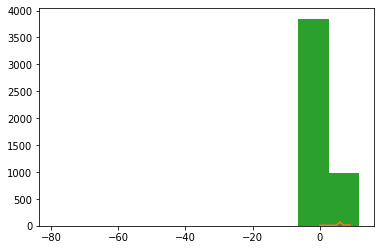

In [22]:
eval_model(unscaled, get_two_layer_m(unscaled))

In [27]:
eval_model(unscaled, get_four_layer_m(unscaled))

Train on 19358 samples
19358/19358 [==============================] - 4s 188us/sample - loss: 28.8529
Train on 19358 samples
19358/19358 [==============================] - 3s 178us/sample - loss: 190.4860
Train on 19358 samples
19358/19358 [==============================] - 3s 177us/sample - loss: 16.6647
Train on 19358 samples
19358/19358 [==============================] - 3s 177us/sample - loss: 21.1203
Train on 19358 samples
19358/19358 [==============================] - 3s 178us/sample - loss: 25.6394
Train on 19358 samples
19358/19358 [==============================] - 3s 178us/sample - loss: 26.1774
Train on 19358 samples
19358/19358 [==============================] - 5s 234us/sample - loss: 24.9623
Train on 19358 samples
19358/19358 [==============================] - 5s 254us/sample - loss: 22.7561
Trained model on 8 epochs for time 30.528220415115356 secs (0.26205261529227497 epochs in second)


20.428638411360662

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 4s 184us/sample - loss: 9.6874 - val_loss: 9.4124
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 174us/sample - loss: 8.7373 - val_loss: 9.4705
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 173us/sample - loss: 8.4346 - val_loss: 9.3226
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 176us/sample - loss: 8.1125 - val_loss: 9.4635
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 172us/sample - loss: 7.7450 - val_loss: 10.0134
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 173us/sample - loss: 7.3482 - val_loss: 10.0451
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 176us/sample - loss: 6.

'mean squared error: 11.413037127017102'

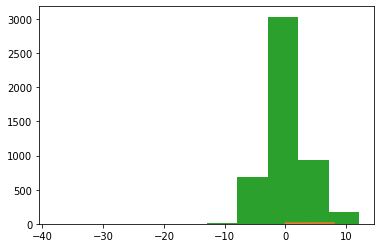

In [16]:
eval_model(unscaled, get_expdec_three_layer_m(unscaled))

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 28us/sample - loss: 28.2550 - val_loss: 17.6431
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 18us/sample - loss: 17.5307 - val_loss: 13.5870
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 19us/sample - loss: 13.9963 - val_loss: 14.0030
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 18us/sample - loss: 14.7077 - val_loss: 13.2746
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 19us/sample - loss: 13.6948 - val_loss: 11.5384
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 19us/sample - loss: 11.4850 - val_loss: 10.3307
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 19us/sample - loss:

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 22us/sample - loss: 7.1229 - val_loss: 9.0392
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 20us/sample - loss: 7.0955 - val_loss: 9.0417
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 21us/sample - loss: 7.0670 - val_loss: 9.0424
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 24us/sample - loss: 7.0371 - val_loss: 9.0423
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 21us/sample - loss: 7.0071 - val_loss: 9.0428
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 18us/sample - loss: 6.9781 - val_loss: 9.0445
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 18us/sample - loss: 6.9501 - va

9.063432207515444

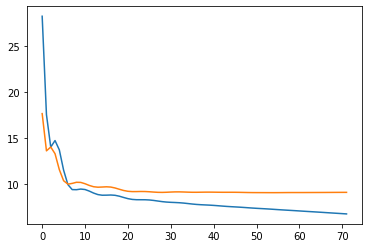

In [49]:
eval_model(unscaled, get_expdec_three_layer_m(unscaled), batch_size=unscaled.X_train.shape[0])

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 104us/sample - loss: 9.7329 - val_loss: 9.4522
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 94us/sample - loss: 8.6732 - val_loss: 9.4169
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 94us/sample - loss: 8.2365 - val_loss: 9.4075
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 93us/sample - loss: 7.9018 - val_loss: 9.5372
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 98us/sample - loss: 7.4684 - val_loss: 9.8459
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 98us/sample - loss: 7.0787 - val_loss: 10.4999
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 96us/sample - loss: 6.6184 - 

12.11095078437917

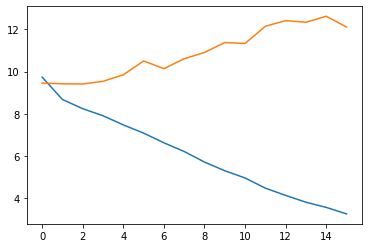

In [50]:
eval_model(unscaled, get_expdec_three_layer_m(unscaled), batch_size=64)

Trying another model ...

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 121us/sample - loss: 37.0973 - val_loss: 20.4611
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 116us/sample - loss: 22.1584 - val_loss: 20.6889
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 113us/sample - loss: 17.7216 - val_loss: 12.6337
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 110us/sample - loss: 11.8790 - val_loss: 14.3453
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 110us/sample - loss: 13.0135 - val_loss: 11.4855
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 111us/sample - loss: 9.9532 - val_loss: 10.6038
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 110us/sample -

9.30521865385334

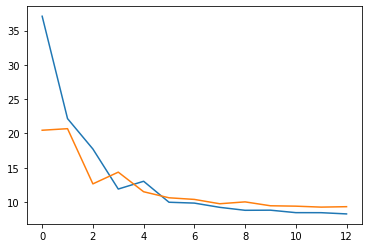

In [57]:
eval_model(unscaled, get_three_layer_m(unscaled), batch_size=unscaled.X_test.shape[0])

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 22s 1ms/sample - loss: 10.0759 - val_loss: 9.4135
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 24s 1ms/sample - loss: 8.8090 - val_loss: 10.0929
Trained model on 2 epochs for time 46.335320472717285 secs (0.04316361642901813 epochs in second)
Loss history:


10.092937119136156

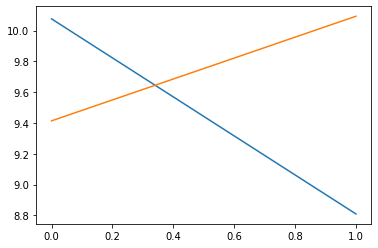

In [58]:
eval_model(unscaled, get_three_layer_m(unscaled), batch_size=32)

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 13s 666us/sample - loss: 10.7479 - val_loss: 9.3627
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 13s 694us/sample - loss: 8.7236 - val_loss: 9.2474
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 15s 799us/sample - loss: 8.3140 - val_loss: 9.3848
Trained model on 3 epochs for time 41.91525459289551 secs (0.07157298766612978 epochs in second)
Loss history:


9.384808346360845

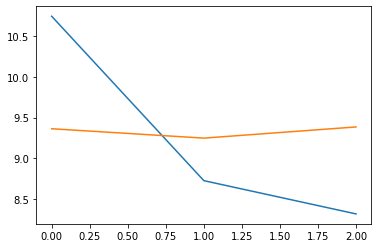

In [59]:
eval_model(unscaled, get_three_layer_m(unscaled), batch_size=64)

## Poisson stuff

In [51]:
def tf_fact(tensor):
    return tf.exp(tf.math.lgamma(tensor + 1.))

In [18]:
from scipy.stats import poisson

def my_poisson_loss(y_actual, y_predicted):
    
    lmbd = tf.keras.backend.cast(y_predicted, tf.keras.backend.floatx())
    k = tf.keras.backend.cast(y_actual, tf.keras.backend.floatx())
    
    return lmbd - k*tf.math.log(1 + lmbd)

def get_my_poisson_twol_m(dataset):
    my_poisson_twol_m = tf.keras.Sequential([
        tf.keras.layers.Dense(simple.X_train.shape[1], input_shape=(dataset.X_train.shape[1],), activation='relu'),
        tf.keras.layers.Dense(1, activation='relu')
    ])
    my_poisson_twol_m.compile(optimizer=tf.keras.optimizers.Adam(), loss=my_poisson_loss)
    
    return my_poisson_twol_m

def get_poisson_twol_m(dataset):
    poisson_twol_m = tf.keras.Sequential([
        tf.keras.layers.Dense(simple.X_train.shape[1], input_shape=(dataset.X_train.shape[1],), activation='relu'),
        tf.keras.layers.Dense(1, activation='relu')
    ])
    poisson_twol_m.compile(optimizer=tf.keras.optimizers.Adam(), loss='poisson')
    
    return poisson_twol_m

def get_poisson_expdec_threel_m(dataset):
    poisson_expdec_threel_m = tf.keras.Sequential([
        tf.keras.layers.Dense(simple.X_train.shape[1], input_shape=(dataset.X_train.shape[1],), activation='relu'),
        tf.keras.layers.Dense(simple.X_train.shape[1]**(1/2), activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    poisson_expdec_threel_m.compile(optimizer=tf.keras.optimizers.Adam(), loss='poisson')
    
    return poisson_expdec_threel_m

def get_my_poisson_expdec_threel_m(dataset):
    my_poisson_expdec_threel_m = tf.keras.Sequential([
        tf.keras.layers.Dense(simple.X_train.shape[1], input_shape=(dataset.X_train.shape[1],), activation='relu'),
        tf.keras.layers.Dense(simple.X_train.shape[1]**(1/2), activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    my_poisson_expdec_threel_m.compile(optimizer=tf.keras.optimizers.Adam(), loss=my_poisson_loss)
    
    return my_poisson_expdec_threel_m

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 32us/sample - loss: 15.7786 - val_loss: 0.5093
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 22us/sample - loss: -0.0152 - val_loss: -1.3761
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 22us/sample - loss: -1.3866 - val_loss: -1.8698
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 22us/sample - loss: -1.8286 - val_loss: -2.0807
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 23us/sample - loss: -2.0318 - val_loss: -2.1907
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 23us/sample - loss: -2.1381 - val_loss: -2.2489
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 22us/sample - loss: 

19358/19358 [==============================] - 0s 23us/sample - loss: -2.3868 - val_loss: -2.3984
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 24us/sample - loss: -2.3878 - val_loss: -2.4067
Trained model on 57 epochs for time 30.410444974899292 secs (1.874355999954873 epochs in second)
Loss history:


'mean squared error: 9.138872917508202'

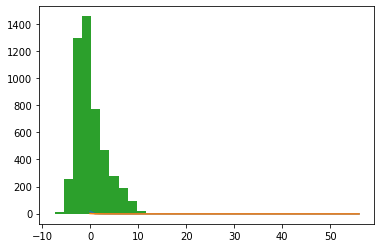

In [21]:
eval_model(unscaled, get_poisson_twol_m(unscaled), batch_size=unscaled.X_test.shape[0])

In [19]:
eval_model(unscaled, get_poisson_expdec_threel_m(unscaled))

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 4s 211us/sample - loss: nan - val_loss: nan
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 175us/sample - loss: nan - val_loss: nan
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 180us/sample - loss: nan - val_loss: nan
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 174us/sample - loss: nan - val_loss: nan
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 175us/sample - loss: nan - val_loss: nan
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 4s 191us/sample - loss: nan - val_loss: nan
Train on 19358 samples, validate on 4840 samples
 1280/19358 [>.............................] - ETA: 3s - loss: nan

KeyboardInterrupt: 

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 164us/sample - loss: nan - val_loss: nan
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 151us/sample - loss: nan - val_loss: nan
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 152us/sample - loss: nan - val_loss: nan
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 157us/sample - loss: nan - val_loss: nan
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 4s 204us/sample - loss: nan - val_loss: nan
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 158us/sample - loss: nan - val_loss: nan
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 172us/sample - loss: nan - val_loss: nan
Train on 19358 sampl

ValueError: Mean Tweedie deviance error with power=1 can only be used on non-negative y_true and strictly positive y_pred.

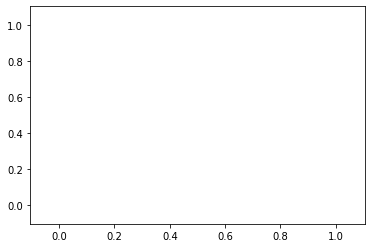

In [22]:
eval_model(unscaled, get_poisson_expdec_threel_m(unscaled), batch_size=32)

## Scaled on poisson

In [20]:
eval_model(compdiags, get_poisson_expdec_threel_m(compdiags), batch_size=compdiags.X_train.shape[0])

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 35us/sample - loss: nan - val_loss: nan
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 21us/sample - loss: nan - val_loss: nan
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 20us/sample - loss: nan - val_loss: nan
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 21us/sample - loss: nan - val_loss: nan
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 21us/sample - loss: nan - val_loss: nan
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 21us/sample - loss: nan - val_loss: nan
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 0s 20us/sample - loss: nan - val_loss: nan
Train on 19358 samples, val

KeyboardInterrupt: 

## My custom poisson

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 178us/sample - loss: -3.3802 - val_loss: -3.5021
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 161us/sample - loss: -3.5032 - val_loss: -3.4992
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 160us/sample - loss: -3.5346 - val_loss: -3.4840
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 164us/sample - loss: -3.5540 - val_loss: -3.3531
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 133us/sample - loss: -3.5642 - val_loss: -3.4602
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 125us/sample - loss: -3.5978 - val_loss: -3.4660
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 122us/sample 

ValueError: Mean Tweedie deviance error with power=1 can only be used on non-negative y_true and strictly positive y_pred.

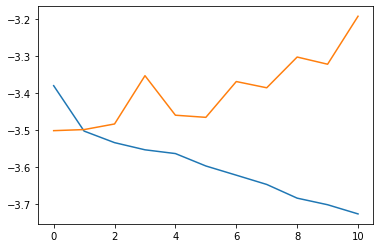

In [118]:
eval_model(unscaled, get_my_poisson_twol_m(unscaled))

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 170us/sample - loss: -1.8034 - val_loss: -2.2944
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 162us/sample - loss: -2.2210 - val_loss: -2.2116
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 160us/sample - loss: -2.3464 - val_loss: -2.0505
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 174us/sample - loss: -2.3201 - val_loss: -2.2506
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 179us/sample - loss: -2.3805 - val_loss: -2.2826
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 151us/sample - loss: -2.5101 - val_loss: -2.1867
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 135us/sample 

ValueError: Mean Tweedie deviance error with power=1 can only be used on non-negative y_true and strictly positive y_pred.

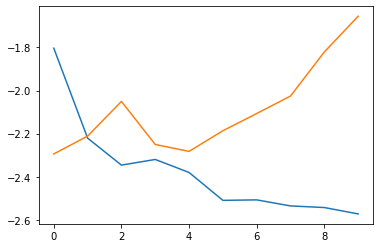

In [86]:
eval_model(unscaled, get_poisson_twol_m(unscaled))

In [40]:
def get_diffs_distr(df, model):
    eval_model(df, model)
    preds = model.predict(unscaled.X_dev)
    difs = preds[:, 0] - unscaled.y_dev
    
    print()
    plt.hist(difs, bins = 40)


Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 162us/sample - loss: 10.2009 - val_loss: 9.9078
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 152us/sample - loss: 9.4306 - val_loss: 10.3397
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 154us/sample - loss: 8.7450 - val_loss: 10.1134
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 156us/sample - loss: 8.6252 - val_loss: 9.5664
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 156us/sample - loss: 8.5316 - val_loss: 11.5307
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 156us/sample - loss: 8.6178 - val_loss: 9.5931
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 159us/sample - loss: 

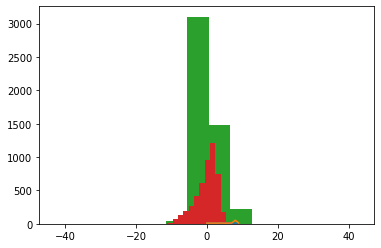

In [41]:
get_diffs_distr(unscaled, get_two_layer_m(unscaled))

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 164us/sample - loss: -1.2752 - val_loss: -2.4511
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 152us/sample - loss: -2.3176 - val_loss: -2.2564
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 157us/sample - loss: -2.4457 - val_loss: -2.4659
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 152us/sample - loss: -2.4851 - val_loss: -2.2565
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 152us/sample - loss: -2.5145 - val_loss: -2.3267
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 156us/sample - loss: -2.4966 - val_loss: -2.2755
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 3s 151us/sample 

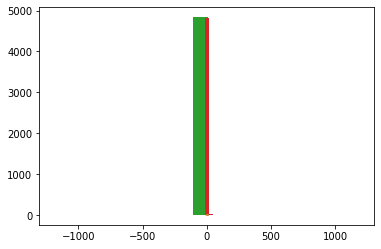

In [42]:
get_diffs_distr(unscaled, get_poisson_twol_m(unscaled))